In [1]:
# import altair as alt
# from vega_datasets import data
# alt.data_transformers.enable("vegafusion")

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from scipy.stats import gamma
from scipy.optimize import curve_fit

import arviz as az
import pymc as pm

from tqdm.notebook import tqdm

import sys
sys.path.append("../src")

from data.GDGT_datasets import load_duncan2023, load_rattanasriampaipong2022

# Helper function(s)

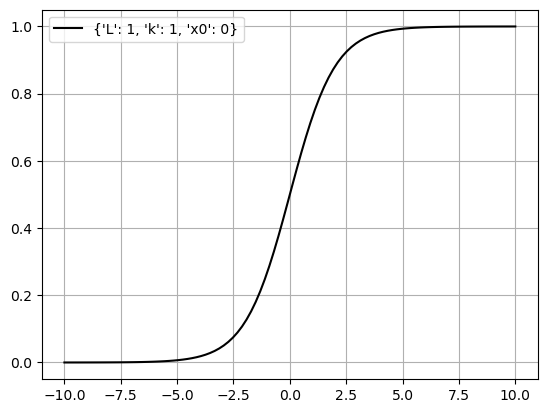

In [2]:
# Logistic curve
def logistic(x,L,k,x0):
    return L/(1+np.exp(-k*(x-x0)))

x = np.linspace(-10,10,100)
fig, ax = plt.subplots(1,1)
p = {"L": 1, "k": 1, "x0": 0}
ax.plot(x,logistic(x,**p),'k-',label=str(p))
ax.legend()
ax.grid()

In [3]:
# adjusted from https://stackoverflow.com/a/60230746/1498309
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.3, 0.3, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

def plot_compounds(df, compound_names, sst_name, ylabel=None):
    fig, ax = plt.subplots(1,1,figsize=(10,2))
    for i, column in enumerate(compound_names):
        sst = df[sst_name]
        x = np.full((len(df), 1), i)
        y = df[column]
        dots = plt.scatter(x, y, s=10, c=sst, marker='.',alpha=1,lw=0)
        jitter_dots(dots)
    plt.xticks(range(len(compound_names)), compound_names)
    xmin, xmax = plt.xlim()
    ax.set_xlim(xmin - 0.3, xmax + 0.3)  # make some room to show the jittered dots
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.1,1.1)
    cbar = plt.colorbar()
    return fig, ax

In [4]:
fnm = "../data/external/woa23_decav91C0_t00_04.nc"
ds = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["t_an"]
# fnm = "../data/external/woa23_decav91C0_s00_04.nc"
# ds2 = xr.open_dataset(fnm,decode_times=False).squeeze(drop=True).sel(depth=slice(0,250))["s_an"]

ds


<xarray.DataArray 't_an' (depth: 27, lat: 720, lon: 1440)> Size: 112MB
[27993600 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 108B 0.0 5.0 10.0 15.0 ... 175.0 200.0 225.0 250.0
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [5]:
# df = pd.read_excel("../data/external/GDGTdata_Antarctica_220923.xlsx", sheet_name="iso modern cal",skiprows=1)

# modern_data = load_duncan2023(as_frame=True)
modern_data = load_rattanasriampaipong2022(as_frame=True)
df = modern_data.frame

compound_names = list(df.columns[0:6].astype(str).values)
sst_name = "SST"

df

,GDGT-0,GDGT-1,GDGT-2,GDGT-3,Crenarchaeol,Cren',Age (Ma),Longitude,Latitude,SST
0,0.411959,0.078292,0.046195,0.004400,0.441156,0.017998,0.0,0.9075,-40.0032,12.202491
1,0.398760,0.075892,0.050295,0.007799,0.445555,0.021698,0.0,17.0363,-34.6213,18.399799
2,0.350800,0.078300,0.062300,0.008600,0.470500,0.029500,0.0,13.1091,-36.4956,17.877609
3,0.379200,0.054900,0.028300,0.006900,0.512100,0.018600,0.0,17.9736,-34.3263,17.311209
4,0.371637,0.071307,0.054405,0.008801,0.463146,0.030703,0.0,7.6704,-39.2945,13.566091
...,...,...,...,...,...,...,...,...,...,...
829,0.078092,0.037196,0.107389,0.021098,0.656434,0.099790,0.0,38.7220,19.4580,28.980209
830,0.074700,0.036700,0.101600,0.019400,0.662200,0.105400,0.0,39.0530,19.1350,29.131990
831,0.080800,0.042200,0.102800,0.018600,0.656400,0.099200,0.0,39.0570,18.6020,29.237310
832,0.090400,0.043000,0.098300,0.019500,0.658300,0.090500,0.0,40.0220,17.3620,29.332390


0it [00:00, ?it/s]

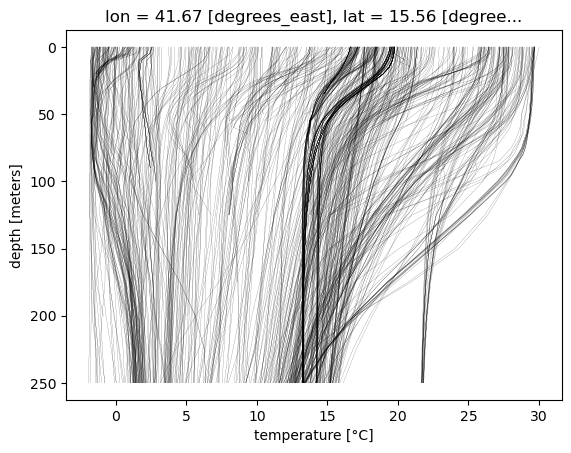

In [6]:
fig, ax = plt.subplots(1,1)

temps = []
gdgts = []

woa_data = []

for name, row in tqdm(df.iterrows()):
    lon0, lat0 = row[["Longitude","Latitude"]].values
    T_profile = ds.interp(lon=lon0, lat=lat0, method="nearest")
    woa_data.append(np.sum(~np.isnan(T_profile.values)))
    temps.append(T_profile.values)
    gdgts.append(row[compound_names].values)
    T_profile.plot(y='depth',ax=ax,color='k',lw=0.1)
ax.invert_yaxis()
ax.set_xlabel("temperature [°C]")
df["woa_data"] = woa_data


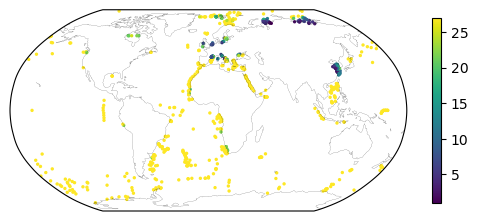

In [7]:
fig, ax = plt.subplots(1,1, subplot_kw={"projection": ccrs.Robinson()})
ax.coastlines(lw=0.1)
ax.set_global()

im = ax.scatter(df["Longitude"],df["Latitude"],c=df["woa_data"],s=2,transform=ccrs.PlateCarree())
plt.colorbar(im,ax=ax, shrink=0.5)

GDGT-0            0.24110
GDGT-1            0.06330
GDGT-2            0.08040
GDGT-3            0.01210
Crenarchaeol      0.54270
Cren'             0.06040
Age (Ma)          0.00000
Longitude       160.60000
Latitude          0.00000
SST              29.43379
woa_data         27.00000
Name: 545, dtype: float64

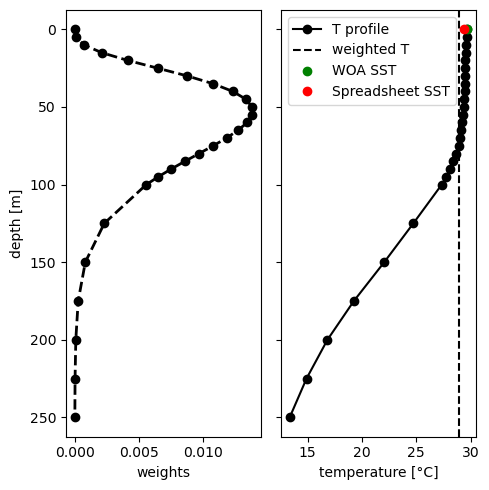

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(5,5), sharey=True)

a = 4.5
b = 15
z = ds.depth
weights = gamma.pdf(z, a, scale=b)

ax[0].plot(weights, z, 
       'ko--', lw=2, label='gamma pdf')
ax[0].invert_yaxis()
# ax[0].set_ylim(255,-5)
ax[0].set_xlabel("weights")
ax[0].set_ylabel("depth [m]")

idx = 545
display(df.iloc[idx])
ax[1].plot(temps[idx],z,'ko-',label='T profile')
valid = ~np.isnan(temps[idx])
T_avg = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
ax[1].axvline(T_avg,color='k',ls='--',label='weighted T')
ax[1].plot(temps[idx][0],z[0], 'go', label='WOA SST')
ax[1].plot(df.iloc[idx][sst_name],z[0], 'ro', label='Spreadsheet SST')

ax[1].set_xlabel("temperature [°C]")
ax[1].legend()
fig.tight_layout()

# Synthetic data

- *GDGT-0*, *GDGT-1*, *GDGT-2*, *GDGT-3*, *Crenarchaeol*, *Cren'* are *Dirichlet*-distributed, with a shape parameter $a$ of length 6.
- The $a$'s depend on temperature $\hat{T}$ and follow *logistic* function (S curves) with parameters $L$, $k$, and $T_0$
  $$a_i(\hat{T}) = \frac{L_i}{(1+e^{-k_i(\hat{T}-T_{0,i})})} \quad \text{with} \quad i \in \{1,2,3,4,5,6\}$$
- Temperature $\hat{T}$ is the depth-averaged seawater temperature with *Gamma*-distributed weights with (global) parameters $\alpha$ and $\beta$.

In [9]:
rng = np.random.default_rng(1234)


N_GDGT = 6
# L = rng.lognormal(2,1,size=N_GDGT)
# L = np.array([10,1,1,0.2,10,0.5])*20 # realistic
L = np.array([136, 10, 10, 3.2, 123, 10]) # realistic
# L = np.logspace(2,0,N_GDGT) + rng.lognormal(0,0.1,size=N_GDGT) # evenly spaced out
print(f"{L = }")

# K = rng.normal(loc=0,scale=0.02, size=N_GDGT)
# K = np.array([-0.04,0.02,0.02,0.05,0.04,0.05]) # realistic
K = np.array([-0.13, -0.24, 0.12, 0.03, -0.04, 0.07]) # realistic
# K = np.linspace(-0.1,0.1,N_GDGT) + rng.normal(loc=0,scale=0.01, size=N_GDGT) # evenly spaced out
print(f"{K = }")

# T0 = rng.normal(loc=15,scale=5,size=N_GDGT) # realistic
# T0 = np.linspace(0,30,N_GDGT) + rng.normal(loc=0,scale=1,size=N_GDGT)
# T0 = 15
T0 = 28 # realistic
T0 = np.array([11.5, 27.4, 6.2, 18.8, 18.1, 24.5]) # realistic
print(f"{T0 = }")

# T_sigma = rng.lognormal(1,2)
# T_sigma = 2
T_sigma = 0 # realistic
print(f"{T_sigma = }")

# alpha = rng.normal(loc=5,scale=2)
alpha = 4.5

print(f"{alpha = }")

# beta = rng.normal(loc=15,scale=3)
beta = 15
print(f"{beta = }")

L = array([136. ,  10. ,  10. ,   3.2, 123. ,  10. ])
K = array([-0.13, -0.24,  0.12,  0.03, -0.04,  0.07])
T0 = array([11.5, 27.4,  6.2, 18.8, 18.1, 24.5])
T_sigma = 0
alpha = 4.5
beta = 15


In [10]:
weights = gamma.pdf(z, alpha, scale=beta)

use_sst = False

N_RECORDS = len(temps)
T_hats = []
valid_idx = []
GDGT_real = []
for idx in tqdm(range(N_RECORDS)):
    if use_sst:
        if ~np.isnan(temps[idx][0]):
            this_T_hat = temps[idx][0]
            T_hats.append(this_T_hat)
            GDGT_real.append(gdgts[idx])
    else:
        valid = ~np.isnan(temps[idx])
        if sum(valid) == len(z):
            this_T_hat = np.average(temps[idx][valid],weights=weights[valid]/np.sum(weights[valid]))
            T_hats.append(this_T_hat)
            valid_idx.append(True)
            GDGT_real.append(gdgts[idx])
        else:
            valid_idx.append(False)
    # else:
        # print(idx)
GDGT_real = np.array(GDGT_real)
print(len(T_hats))

  0%|          | 0/834 [00:00<?, ?it/s]

602


In [11]:
np.isnan(T_hats).any()

False

(27, 602) 602


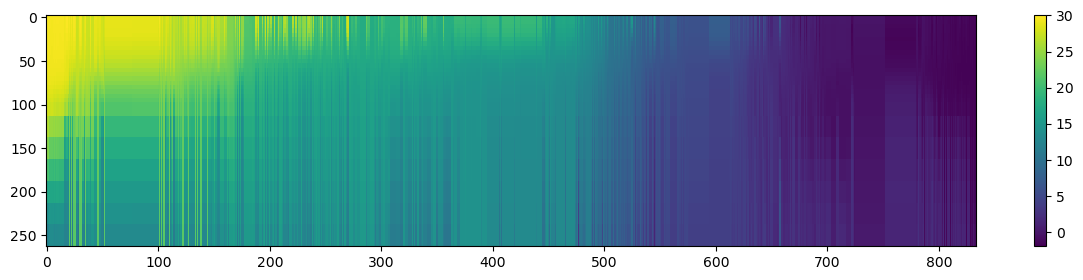

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
XX, YY = np.meshgrid(np.arange(N_RECORDS)[valid_idx],z)
Z = np.array(temps)[valid_idx].T
print(Z.shape, len(T_hats))

# sort by values in T_hats
sorted_idx = np.argsort(T_hats)[::-1]

im  = ax.pcolormesh(XX,YY,Z[:,sorted_idx])
plt.colorbar(im,ax=ax)
ax.invert_yaxis()

In [13]:
synthetic_proxy_names = [f"s{k}" for k in compound_names]
a = {}
for i in tqdm(range(N_GDGT)):
    this_name = synthetic_proxy_names[i]
    this_T_hats = rng.normal(T_hats,T_sigma)
    a[this_name] = logistic(this_T_hats,L[i],K[i],T0[i])


  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
df_a = pd.DataFrame(a)
# display(df_a)

# The rows in `df_a` are the shape coefficients for the *Dirichlet* distribution
synth_data = []
for _,row in df_a.iterrows():
    synth_data.append(rng.dirichlet(row.values))

df_synth = pd.DataFrame(synth_data,columns=synthetic_proxy_names)
df_synth[sst_name] = T_hats

display(df_synth)

,sGDGT-0,sGDGT-1,sGDGT-2,sGDGT-3,sCrenarchaeol,sCren',SST
0,0.483359,0.037843,0.065631,0.012958,0.391308,0.008901,11.466676
1,0.339298,0.061932,0.050707,0.027333,0.477911,0.042820,16.659500
2,0.389830,0.048574,0.071306,0.006680,0.465897,0.017713,16.967307
3,0.365877,0.083782,0.054252,0.013756,0.459637,0.022697,14.744436
4,0.348337,0.068646,0.044673,0.000694,0.511471,0.026179,12.934601
...,...,...,...,...,...,...,...
597,0.194741,0.024547,0.072639,0.046227,0.617464,0.044382,27.036164
598,0.158790,0.090858,0.123633,0.026955,0.540276,0.059487,27.277041
599,0.181355,0.027010,0.052264,0.028666,0.616706,0.093999,27.393556
600,0.185781,0.038997,0.075633,0.005774,0.594965,0.098849,26.863125


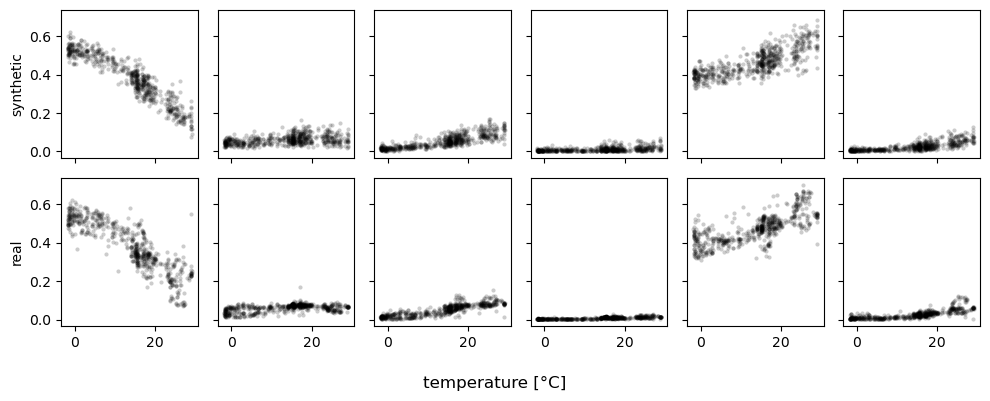

In [15]:
fig, ax = plt.subplots(2,6, sharex=True, sharey=True, figsize=(10,4))
for i in range(6):
    this_synth = synthetic_proxy_names[i]
    ax[0,i].plot(T_hats, df_synth[this_synth],'k.',mew=0, alpha=0.2)
    ax[1,i].plot(T_hats,GDGT_real[:,i],'k.',mew=0, alpha=0.2)
ax[0,0].set_ylabel("synthetic")
ax[1,0].set_ylabel("real")
fig.supxlabel("temperature [°C]")
fig.tight_layout()

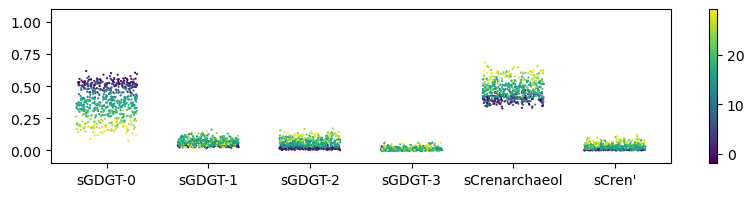

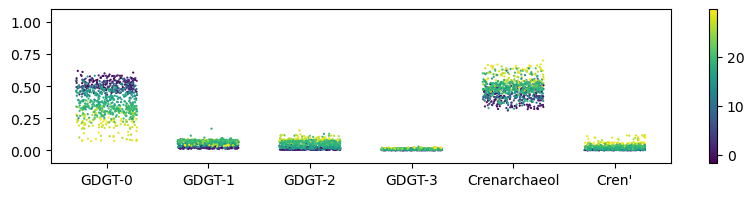

In [16]:
fig, ax = plot_compounds(df_synth, synthetic_proxy_names, sst_name)
fig, ax = plot_compounds(df, compound_names, sst_name)

# Inference of synthetic data

In [17]:
# inputs are T_hats (but will be T(z) in the future)
# outputs are GDGTs 1-6

obs = df_synth[synthetic_proxy_names].values
# obs = GDGT_real
print(obs.shape)

N_SAMPLES = 100

with pm.Model() as model:
    # priors
    L_ = pm.Lognormal("L", mu=1, sigma=2, shape=(N_GDGT,))
    print(f"{L_.eval() = }")

    K_ = pm.Normal("K", mu=0, sigma=0.1, shape=(N_GDGT,))
    print(f"{K_.eval() = }")

    T0_ = pm.Normal("T0", mu=20, sigma=5, shape=(N_GDGT,))
    # T0_ = pm.Normal("T0", mu=10, sigma=5)
    print(f"{T0_.eval() = }")

    # T_sigma_ = pm.HalfNormal("Tsigma", sigma=1)
    # print(f"{T_sigma_.eval() = }")

    # alpha_ = pm.Normal("alpha", mu=5, sigma=2)
    # print(f"{alpha_.eval() = }")

    # beta_ = pm.Normal("beta", mu=15, sigma=3)
    # print(f"{beta_.eval() = }")

    # T_hats_ = pm.Normal("T_hats", mu=T_hats,sigma=T_sigma_)
    a_ = []
    for i in range(N_GDGT):
        a_.append(L_[i]/(1+pm.math.exp(-K_[i]*(T_hats-T0_[i]))))
    a_ = pm.Deterministic("a", pm.math.stack(a_).T)
    print(f"{a_.eval().shape = }")

    GDGT_ = pm.Dirichlet("GDGT", a=a_, observed=obs, shape=obs.shape)
    print(f"{GDGT_.eval().shape = }")

    # Sample from prior
    idata = pm.sample_prior_predictive(samples=N_SAMPLES) 



(602, 6)
L_.eval() = array([ 0.32170367,  4.7526785 , 12.56548289,  1.45778876,  2.25144557,
        0.32300765])
K_.eval() = array([-0.18448723, -0.12679367,  0.00237576, -0.00589627,  0.00359711,
       -0.01169627])
T0_.eval() = array([21.39340086, 11.87333772, 25.99783009, 13.15200138, 21.5181069 ,
       14.7817241 ])
a_.eval().shape = (602, 6)
GDGT_.eval().shape = (602, 6)


Sampling: [GDGT, K, L, T0]


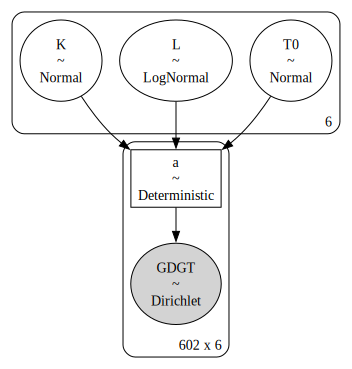

In [18]:
gv = pm.model_to_graphviz(model)
gv

0 77
(602, 6)
1 21
(602, 6)
2 79
(602, 6)


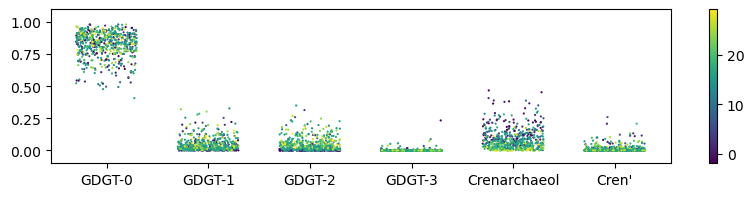

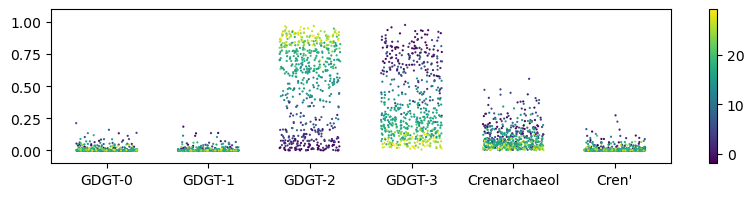

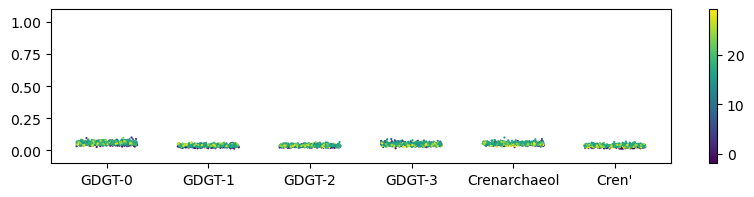

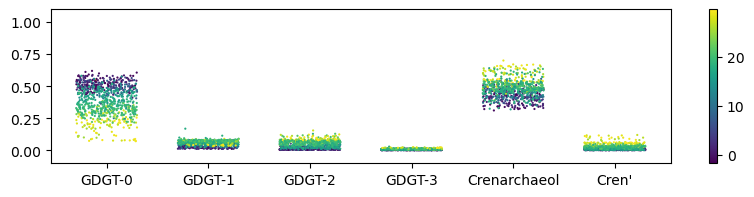

In [19]:
N = 2
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    print(j,i)
    if j < N:
        data = idata.prior_predictive.stack(samples=("chain","draw")).isel(samples=i)
#     data = idata.prior_predictive.stack(samples=("chain","draw")).quantile(0.97,"samples")
    else:
        data = idata.prior_predictive.stack(samples=("chain","draw")).median("samples")
    print(data["GDGT"].shape)
    df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
    df_test[sst_name] = df_synth[sst_name]
    _, _ = plot_compounds(df_test, compound_names, sst_name)
_, _ = plot_compounds(df, compound_names, sst_name)

In [20]:
# posterior sampling
with model:
    idata.extend(pm.sample(1000, tune=2000))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [L, K, T0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 194 seconds.


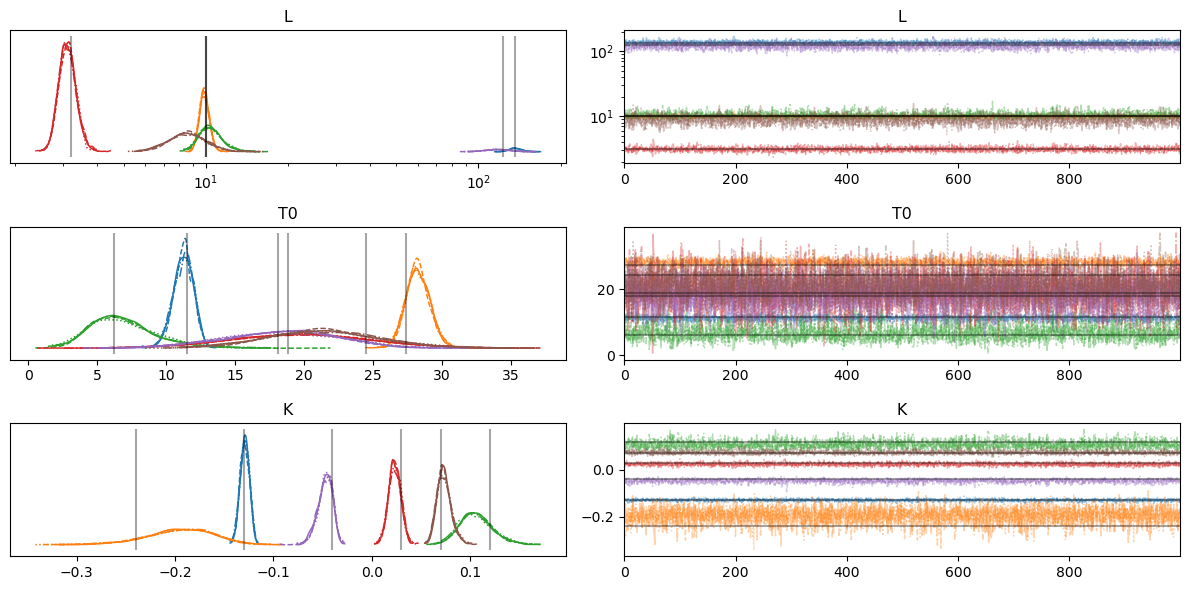

In [21]:
# var_names = ["L", "T0", "Tsigma", "k"]
var_names = ["L", "T0", "K"]

lines = (
    ('L', {}, L),
    ('T0', {}, T0),
    # ('Tsigma', {}, T_sigma),
    ('K', {}, K),
)

ax = az.plot_trace(idata,var_names=var_names, lines=lines)
ax[0,0].set_xscale("log")
ax[0,1].set_yscale("log")
plt.tight_layout()

In [22]:
az.summary(idata,var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
L[0],137.211,7.281,123.962,150.747,0.157,0.111,2214.0,2237.0,1.0
L[1],9.911,0.425,9.168,10.754,0.009,0.006,2483.0,2468.0,1.0
L[2],10.594,1.102,8.686,12.676,0.027,0.019,1739.0,1939.0,1.0
L[3],3.133,0.229,2.737,3.567,0.004,0.003,3575.0,2935.0,1.0
L[4],119.127,11.425,98.963,140.907,0.236,0.167,2329.0,2734.0,1.0
L[5],8.862,1.398,6.271,11.362,0.027,0.019,2697.0,2605.0,1.0
T0[0],11.235,0.731,9.794,12.495,0.015,0.010,2546.0,2670.0,1.0
T0[1],28.260,0.879,26.599,29.873,0.018,0.013,2354.0,2464.0,1.0
T0[2],6.914,2.456,2.918,11.778,0.062,0.045,1656.0,1787.0,1.0
T0[3],19.653,4.986,10.389,29.178,0.080,0.057,3873.0,3033.0,1.0


In [23]:
with model:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [GDGT]


Output()

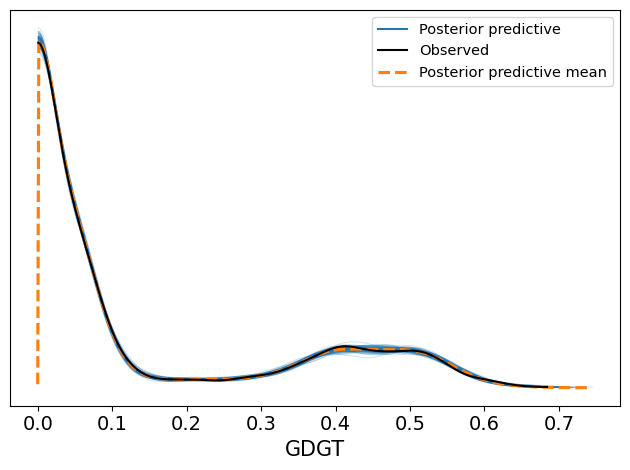

In [24]:
az.plot_ppc(idata, num_pp_samples=100)
plt.tight_layout()

0 38 2
(602, 6)
1 37 2
(602, 6)
2 77 2
(602, 6)


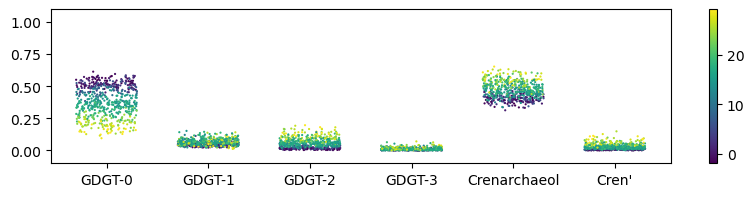

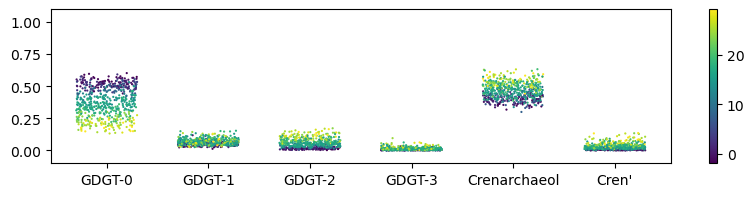

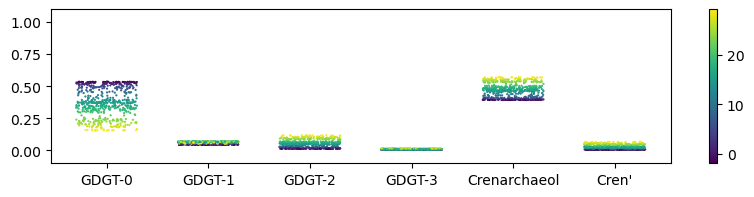

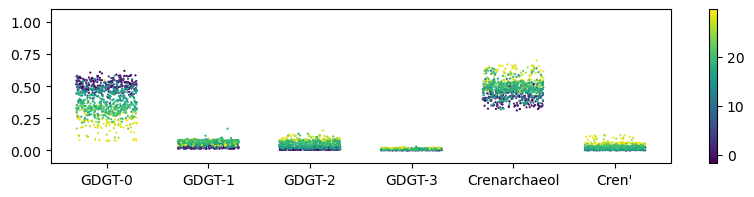

In [25]:
N = 2
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    print(j,i,N)
    if j < N:
        data = idata.posterior_predictive.stack(samples=("chain","draw")).isel(samples=i)
    else:
        data = idata.posterior_predictive.stack(samples=("chain","draw")).median("samples")
    print(data["GDGT"].shape)
    df_test = pd.DataFrame(data=data["GDGT"],columns=compound_names)
    df_test[sst_name] = df_synth[sst_name]
    _, _ = plot_compounds(df_test, compound_names, sst_name)
# fig, ax = plot_compounds(df_synth, synthetic_proxy_names, sst_name)
fig, ax = plot_compounds(df, compound_names, sst_name)

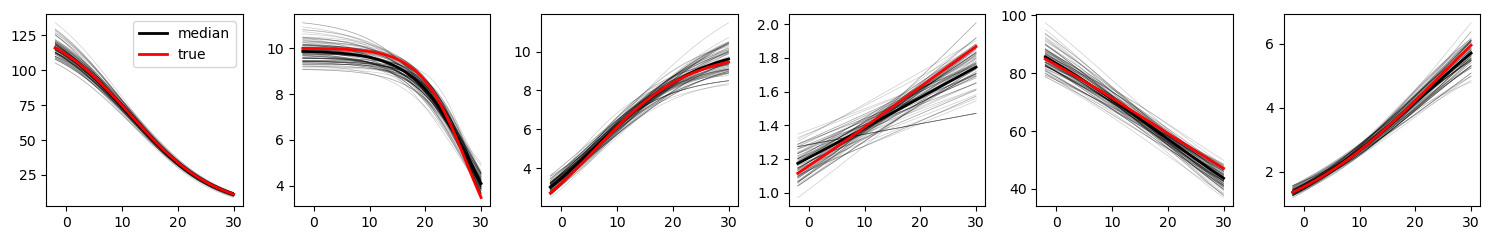

In [26]:
fig, ax = plt.subplots(1,6,figsize=(15,2.5),sharex=True)

sst = np.linspace(-2,30,100)

N = 100
for j,i in enumerate(np.random.choice(range(N_SAMPLES),N+1)):
    # print(j,i,N)
    if j < N:
        p = np.array([idata.posterior[k].stack(samples=("chain","draw")).isel(samples=i).values for k in ["L", "K", "T0"]])
        # L_pp = idata.posterior["L"].stack(samples=("chain","draw")).isel(samples=i).values
        # K_pp = idata.posterior["k"].stack(samples=("chain","draw")).isel(samples=i).values
        # T0_pp = idata.posterior["T0"].stack(samples=("chain","draw")).isel(samples=i).values
        for k in range(N_GDGT):
            ax[k].plot(sst,logistic(sst,*p[:,k]),'k-',lw=0.5,alpha=0.2)
            # ax[k].plot(sst,logistic(sst,L_pp[k],K_pp[k], T0_pp),'k-',lw=1,alpha=0.1)
        # print(p.shape)
    else:
        p_median = np.array([idata.posterior[k].stack(samples=("chain","draw")).median("samples").values for k in ["L", "K", "T0"]])
        # L_pp = idata.posterior["L"].stack(samples=("chain","draw")).mean("samples").values
        # K_pp = idata.posterior["k"].stack(samples=("chain","draw")).mean("samples").values
        # T0_pp = idata.posterior["T0"].stack(samples=("chain","draw")).mean("samples").values
        for k in range(N_GDGT):
            ax[k].plot(sst,logistic(sst,*p_median[:,k]),'k-',lw=2,label='median')
            # ax[k].plot(sst,logistic(sst,L_pp[k],K_pp[k], T0_pp),'w-',lw=1)
        # print(p_mean.shape)

# true functions
for k in range(N_GDGT):
    
    ax[k].plot(sst,logistic(sst,L[k], K[k], T0[k]),'r-',lw=2,label='true')
ax[0].legend()
fig.tight_layout()

In [27]:
with model:
    pm.compute_log_likelihood(idata)

Output()

In [28]:
az.loo(idata)

Computed from 4000 posterior samples and 602 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  8309.61    58.30
p_loo       14.76        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.70]   (good)      602  100.0%
   (0.70, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [29]:
# az.loo_pit(idata=idata, y="GDGT")